# Optimization
--------------------

In this notebook, we will take a look at the main features of the code through simple examples using the `Optimization` class.

## The simplest optimization
------------------------------------

In principle, the only class needed in a standard script is the `Optimization` class. This is the minimal and most straightforward way to perform a spatial clustering on a system.

To be instantiated, this class only requires one positional argument: the path to a trajectory file in a supported format (or an instance of `pysc.trajectory.Trajectory`). See **notebook #1** for details about trajectories.

Let's have a look, using a simple Lennard-Jones binary mixture known as a Kob-Andersen mixture:

In [1]:
from pysc import Optimization

opt = Optimization('../data/kalj_N150.xyz')
opt.run()

This is the most minimalist script: we open a trajectory file through the `Optimization` class, and use the default parameters to perform a clustering.

Other parameters can be set when creating an optimization:
* `descriptor`: the type of structural descriptor to use to perform the clustering. This must be a short string or an instance of `pysc.descriptor.StructuralDescriptor`. The default value is set to `"gr"`, which is the symbol of the `RadialDescriptor` class. Setting this parameter to an instance is also possible.
* `scaling`: type of feature scaling to apply on the data. Default is `None`, but a short string (e.g. `"zscore"` or `"minmax"`) or an instance of the associated classes is also possible.
* `dim_redux`: dimensionality reduction method. Default value is `None`, but a short string (e.g. `"pca"` or `"tsne"`) or an instance of the associated classes is also possible.
* `clustering`: clustering algorithm. Default is `"kmeans"`, but other short strings (`"gmm"` or `"cinf"`) or an instance of the associated classes is also possible.

With these first three lines of code above, we basically used the radial distribution of the particles to form clusters using the K-Means algorithm (no feature scaling or dimensionality reduction by default). Let's have a look at the bulk radial distribution, and the distributions restricted to the clusters:

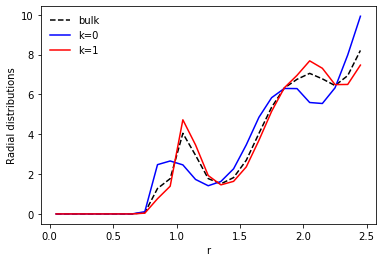

In [12]:
import matplotlib.pyplot as plt

# grid and average distribution
r = opt.descriptor.grid
p_r = opt.descriptor.average

# dataset: all the individual radial distributions of the particles
data = opt.descriptor.features
# distributions of the clusters
pk_r = opt.clustering.centroids(data)

# plot
plt.plot(r, p_r, c='k', ls='--', label='bulk')
plt.plot(r, pk_r[0], c='b', label='k=0')
plt.plot(r, pk_r[1], c='r', label='k=1')
plt.xlabel('r')
plt.ylabel('Radial distributions')
plt.legend(frameon=False)
plt.show()

We see that the bulk distribution (dashed line) has been split into two quite different distributions. Let's have a look at a more common quantity: the radial distribution function, $g(r)$.

The class `RadialDescriptor`, used here to compute the radial correlations, implements a normalization function that allows us to get a $g(r)$ from the average distributions:

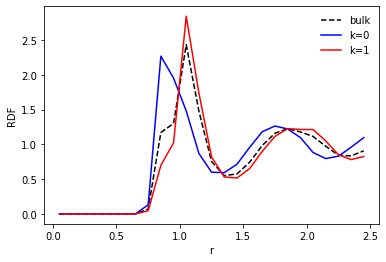

In [3]:
# normalization function
norm = opt.descriptor.normalize_gr

# plot normalized g(r)
plt.plot(r, norm(p_r), c='k', ls='--', label='bulk')
plt.plot(r, norm(pk_r[0]), c='b', label='k=0')
plt.plot(r, norm(pk_r[1]), c='r', label='k=1')
plt.xlabel('r')
plt.ylabel('RDF')
plt.legend(frameon=False)
plt.show()

The numbers, fractions and labels of the clusters are accessible through the following attributes:

In [4]:
print('Populations:', opt.populations)
print('Fractions;', opt.fractions)
print('Labels:', opt.labels)

Populations: [ 4549 10601]
Fractions; [0.30026403 0.69973597]
Labels: [1 1 1 ... 0 0 0]


Unless disabled with `opt.disable_output()`, a set output files is written after running the optimization. Some are written by default while some need to be enabled. The output files include:
* `"trajectory"`: the optimized trajectory file with an additional column for the clusters' labels (if the output format allows it) ;
* `"log"`: a log file with all the relevant information about the optimization ;
* `"centroids"`: a data file with the centroids of the clusters, using the raw features from the descriptor ;
* `labels`: a text file with the clusters' labels only ;
* `"dataset"`: a data file with the raw features from the descriptor ;

All the information regarding output files is stored in the `output_metadata` attribute (a dictionary) :

In [5]:
# all possible output files
print(opt.output_metadata.keys())

dict_keys(['trajectory', 'log', 'centroids', 'labels', 'dataset'])


Each of these files has its specific options, for example:

In [6]:
# options for the output trajectory
print(opt.output_metadata['trajectory'].keys())

# default values of some options
print('Enable output:', opt.output_metadata['trajectory']['enable'])
print('Output format:', opt.output_metadata['trajectory']['fmt'])

dict_keys(['enable', 'writer', 'filename', 'fmt', 'backend', 'additional_fields', 'precision'])
Enable output: True
Output format: xyz


This can be changed through the method `set_output_metadata`, for example:

In [7]:
opt.set_output_metadata('trajectory', 
                        filename='my_traj.xyz.gz',
                        fmt='rumd')

If no `filename` is provided for the output files, a default naming convention will be used.

## A customized optimization
-------------------------------------

Let us look at a different example, where the `Optimization` needs to be set differently.

We consider a cubic crystal in which some particles have been dislocated from their original lattice positions. We use angular correlations, a standard feature scaling method (Z-score) and a linear dimensionality reduction technique (PCA) to find the clusters:

In [8]:
from pysc.descriptor import BondAngleDescriptor
from pysc import Trajectory, PCA

# trajectory
xtal_traj = Trajectory('../data/dislocation_N8000.xyz')

# bond-angle descriptor
D_ba = BondAngleDescriptor(xtal_traj)
X = D_ba.compute()

# dimensionality reduction method
redux = PCA(n_components=2)

# optimization
xtal_opt = Optimization(xtal_traj,
                        descriptor=D_ba,
                        scaling='zscore',
                        dim_redux=redux,  
                        clustering='kmeans')
xtal_opt.clustering.n_init = 100
xtal_opt.run()

**N.B.** the raw features, rescaled features, and features in the reduced space are accesible through the attributes `features`, `scaled_features` and `reduced_features` respectively.

Let's look at the clusters in the 2D latent space found by dimensionality reduction method:

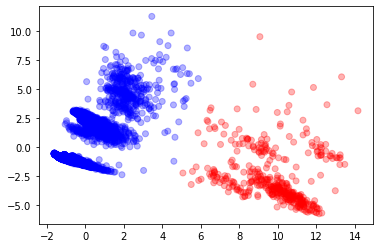

In [9]:
import numpy as np

# features in latent space and labels
X_red = xtal_opt.reduced_features
labels = xtal_opt.labels

# scatter plot of latent space with clusters' labels
c = np.array(['b', 'r'])
plt.scatter(X_red[:,0], X_red[:,1], c=c[labels], alpha=0.3)
plt.show()

If we now look at the centroids of the clusters (bond angle distribution functions):

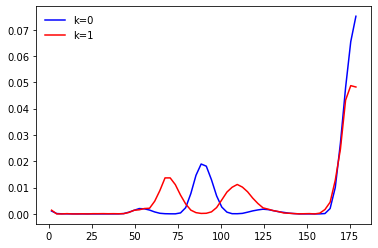

In [10]:
theta = D_ba.grid
q_k = xtal_opt.clustering.centroids(X)
norm_ba = D_ba.normalize_sin

plt.plot(theta, norm_ba(q_k[0]), c='b', label='k=0')
plt.plot(theta, norm_ba(q_k[1]), c='r', label='k=1')
plt.legend(frameon=False)
plt.show()

This is what is expected for particles on the lattice and dislocated particles. With this simple example, we can look at the particles in real space by plotting their positions in the $(O,x,y)$ plane and color them according to their clusters:

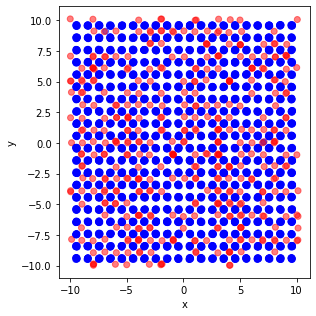

In [11]:
# positions
pos = xtal_traj[0].dump('pos')
x, y = pos[:,0], pos[:,1]

# plot positions in the plane (O,x,y)
plt.figure(figsize=(4.5,4.5))
plt.scatter(x, y, c=c[labels], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()